In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from quantbullet.preprocessing.transformers import FlatRampTransformer
from quantbullet.dfutils import get_bins_and_labels

In [2]:
np.random.seed(42)
n_samples = int( 10e4 )
df = pd.DataFrame({
    'x1': 10 + 3 * np.random.randn(n_samples),
    'x2': 20 + 3 * np.random.randn(n_samples),
    'x3': np.random.choice([0, 1, 2], size=n_samples, p=[0.25, 0.25, 0.5])
})

df['x3'] = df['x3'].astype('category')

df['y'] = np.cos(df['x1']) + np.sin(df['x2']) + \
    np.random.randn(n_samples) * 0.5 + \
    np.random.normal(loc = df['x3'].cat.codes, scale=0.5) + 10

x1_trans = FlatRampTransformer(
    knots = list( np.arange(4, 16, 1 ) ),
    include_bias=True
)

x2_trans = FlatRampTransformer(
    knots = list( np.arange(14, 26, 1 ) ),
    include_bias=True
)

train_df = np.concatenate([
    x1_trans.fit_transform(df['x1']),
    x2_trans.fit_transform(df['x2']),
    pd.get_dummies(df['x3'], prefix='x3') * 1
], axis=1)

train_df = pd.DataFrame(train_df, columns = x1_trans.get_feature_names_out().tolist() 
                        + x2_trans.get_feature_names_out().tolist()
                        + [ 'x3_' + str(cat) for cat in df['x3'].cat.categories.tolist() ])

In [3]:
x1_bins, x1_labels = get_bins_and_labels(cutoffs=list( np.arange(4, 16, 1 ) ) )
x2_bins, x2_labels = get_bins_and_labels(cutoffs=list( np.arange(14, 26, 1 ) ) )

In [4]:
df['x1_bins'] = pd.cut( df['x1'], bins=x1_bins, labels=x1_labels )
df['x2_bins'] = pd.cut( df['x2'], bins=x2_bins, labels=x2_labels )

In [5]:
train_df.head()

,x1_bias,x1_le_4,x1_4_5,x1_5_6,x1_6_7,x1_7_8,x1_8_9,x1_9_10,x1_10_11,x1_11_12,...,x2_19_20,x2_20_21,x2_21_22,x2_22_23,x2_23_24,x2_24_25,x2_gt_25,x3_0,x3_1,x3_2
0,1.0,4.0,5.0,6.0,7.0,8.0,9.0,10.000000,11.0,11.490142,...,20.000000,21.0,22.000000,23.0,23.091784,24.0,25.0,0.0,1.0,0.0
1,1.0,4.0,5.0,6.0,7.0,8.0,9.0,9.585207,10.0,11.000000,...,19.000000,20.0,21.000000,22.0,23.000000,24.0,25.0,0.0,0.0,1.0
2,1.0,4.0,5.0,6.0,7.0,8.0,9.0,10.000000,11.0,11.943066,...,20.000000,21.0,21.726312,22.0,23.000000,24.0,25.0,0.0,0.0,1.0
3,1.0,4.0,5.0,6.0,7.0,8.0,9.0,10.000000,11.0,12.000000,...,19.000000,20.0,21.000000,22.0,23.000000,24.0,25.0,0.0,0.0,1.0
4,1.0,4.0,5.0,6.0,7.0,8.0,9.0,9.297540,10.0,11.000000,...,19.017792,20.0,21.000000,22.0,23.000000,24.0,25.0,0.0,1.0,0.0


In [6]:
feature_groups = {'x1': x1_trans.get_feature_names_out().tolist(), 
                  'x2': x2_trans.get_feature_names_out().tolist(),
                  'x3': [ 'x3_' + str(cat) for cat in df['x3'].cat.categories.tolist() ]}

## Linear Product Regression Model With Scipy Least Squares Optimizer

In [7]:
from quantbullet.optimizer import LinearProductModelScipy

lprm = LinearProductModelScipy( xtol=1e-12, gtol=1e-12, ftol=1e-12 )

In [8]:
lprm.fit( X=train_df, y=df['y'], feature_groups=feature_groups, verbose=1 )

`ftol` termination condition is satisfied.
Function evaluations 28, initial cost 5.0805e+13, final cost 2.6318e+04, first-order optimality 7.17e-01.


In [9]:
df['model_predict'] = lprm.predict(train_df)

In [10]:
from sklearn.metrics import mean_squared_error
mse = mean_squared_error(df['y'], df['model_predict'])
print(f'Mean Squared Error: {mse:.4f}')

mse_avg = mean_squared_error(df['y'], np.full_like(df['y'], df['y'].mean()))
print(f'Mean Squared Error (Average Prediction): {mse_avg:.4f}')

Mean Squared Error: 0.5264
Mean Squared Error (Average Prediction): 2.1805


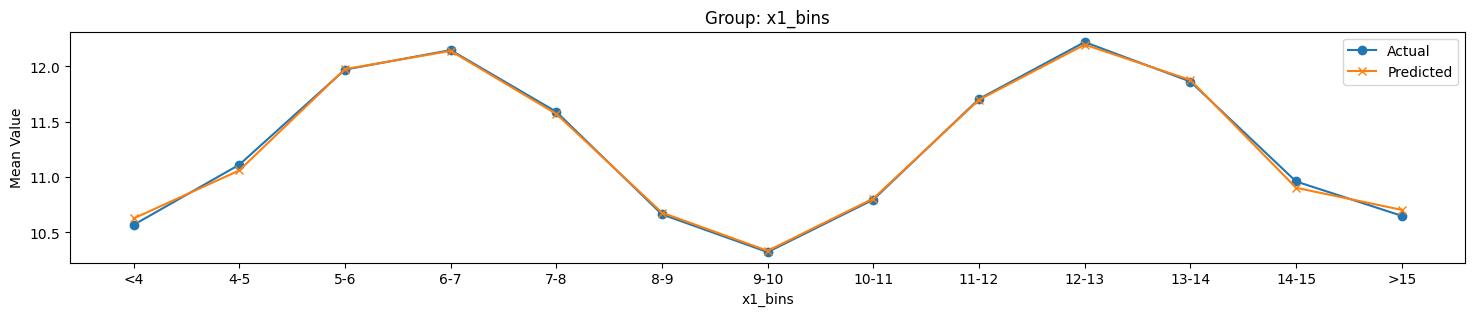

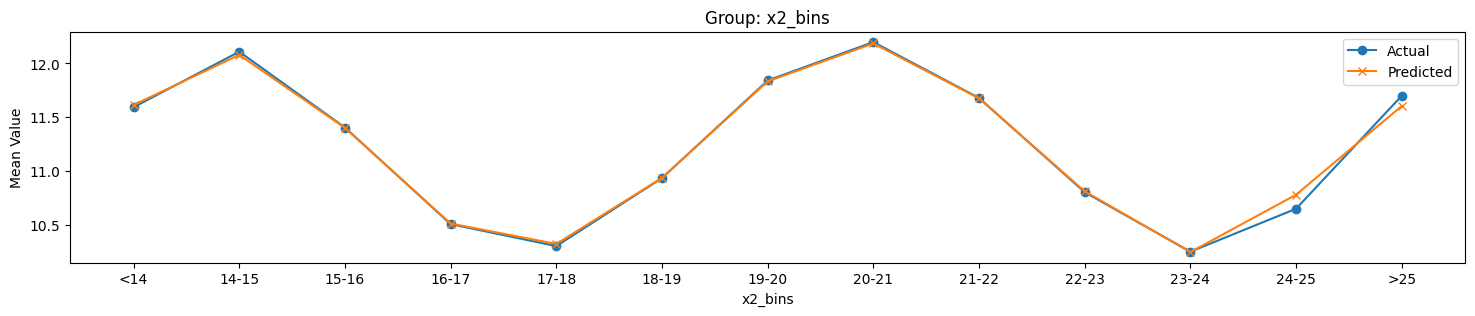

In [11]:
for group in ['x1_bins', 'x2_bins']:
    plt.figure(figsize=(18, 3))
    summary = df.groupby(group, observed=True).agg({'y': 'mean', 'model_predict': 'mean'})
    plt.plot(summary.index, summary['y'], label='Actual', marker='o')
    plt.plot(summary.index, summary['model_predict'], label='Predicted', marker='x')
    plt.title(f'Group: {group}')
    plt.xlabel(group)
    plt.ylabel('Mean Value')
    plt.legend()

## Linear Product Regression Model Block Coordinate Descent

In [12]:
from quantbullet.optimizer import LinearProductModelOLS

lprm_ols = LinearProductModelOLS()

In [13]:
lprm_ols.fit( train_df, df['y'], feature_groups=feature_groups, n_iterations=10, early_stopping_rounds=5 )

Iteration 1/10, MSE: 0.5270
Iteration 2/10, MSE: 0.5269
Iteration 3/10, MSE: 0.5269
Iteration 4/10, MSE: 0.5269
Iteration 5/10, MSE: 0.5269
Iteration 6/10, MSE: 0.5269
Early stopping at iteration 6 with MSE: 0.5269


In [14]:
df['model_predict_BCD'] = lprm_ols.predict(train_df)

In [15]:
lprm_ols.bias_one_coef_dict

{'x1': {'x1_bias': np.float64(1.0),
  'x1_le_4': np.float64(-0.015034826248972202),
  'x1_4_5': np.float64(0.06945698653595488),
  'x1_5_6': np.float64(0.03519929754705049),
  'x1_6_7': np.float64(-0.010856971868226333),
  'x1_7_8': np.float64(-0.053003704938757244),
  'x1_8_9': np.float64(-0.04487360882236337),
  'x1_9_10': np.float64(0.004934310373909145),
  'x1_10_11': np.float64(0.04897014972561836),
  'x1_11_12': np.float64(0.04934698955566579),
  'x1_12_13': np.float64(0.0038340681388803546),
  'x1_13_14': np.float64(-0.0436330524665647),
  'x1_14_15': np.float64(-0.06524519785637907),
  'x1_gt_15': np.float64(0.020939169673639534)},
 'x2': {'x2_bias': np.float64(1.0),
  'x2_le_14': np.float64(0.0721820084079158),
  'x2_14_15': np.float64(-0.03443248911270925),
  'x2_15_16': np.float64(-0.13061193403459456),
  'x2_16_17': np.float64(-0.0933005256221999),
  'x2_17_18': np.float64(0.03122801656814888),
  'x2_18_19': np.float64(0.12266016259296776),
  'x2_19_20': np.float64(0.104598

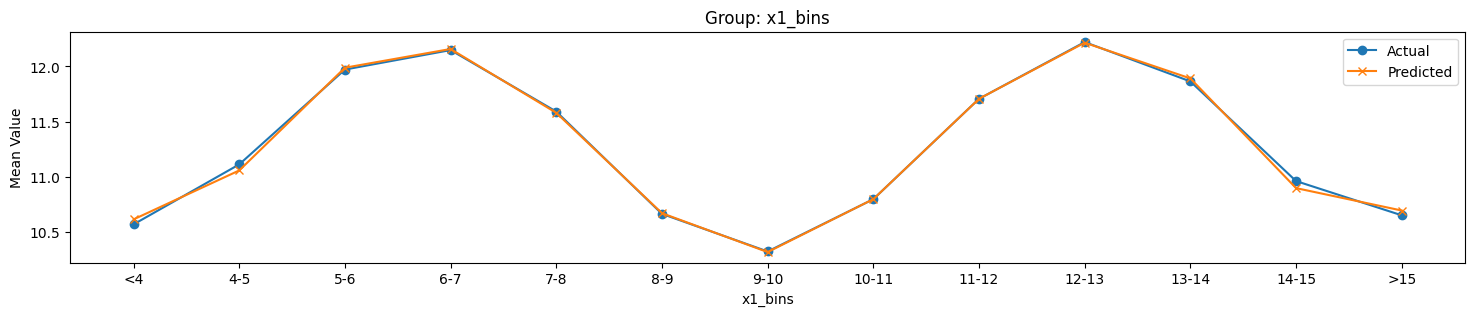

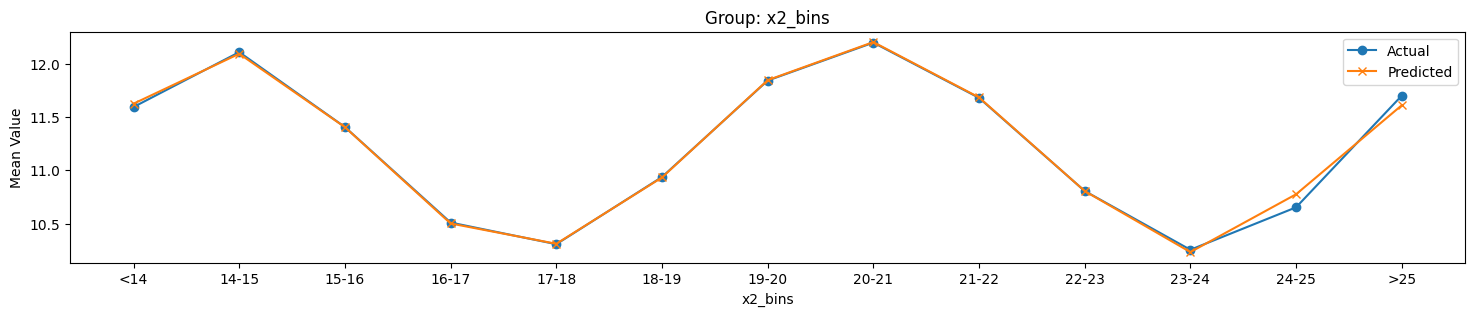

In [16]:
for group in ['x1_bins', 'x2_bins']:
    plt.figure(figsize=(18, 3))
    summary = df.groupby(group, observed=True).agg({'y': 'mean', 'model_predict_BCD': 'mean'})
    plt.plot(summary.index, summary['y'], label='Actual', marker='o')
    plt.plot(summary.index, summary['model_predict_BCD'], label='Predicted', marker='x')
    plt.title(f'Group: {group}')
    plt.xlabel(group)
    plt.ylabel('Mean Value')
    plt.legend()

## Appendix: Manual Alternating Optimization ( before writing into classes )

In [17]:
def group_feature_columns(columns):
    """
    Group feature column names by their root prefix before the first underscore.

    Parameters
    ----------
    columns : list-like
        Iterable of column names (e.g., DataFrame.columns).

    Returns
    -------
    dict
        { root_name : [list of full column names in original order] }
    """
    groups = {}
    for col in columns:
        # Split at first underscore
        root = col.split("_", 1)[0] if "_" in col else col
        groups.setdefault(root, []).append(col)
    return groups


In [18]:
feature_groups = group_feature_columns(train_df.columns)
n_features = train_df.shape[1]
n_obs = train_df.shape[0]
y = df['y'].values

In [19]:
feature_blocks = { key: train_df[feature_groups[key]].values for key in feature_groups }
init_params_blocks = {key: np.ones(len(feature_groups[key]), dtype=float) for key in feature_groups}

def forward(params_blocks, X_blocks):
    if len(params_blocks) != len(X_blocks):
        raise ValueError("Number of parameter blocks must match number of feature blocks.")
    
    result = np.ones(n_obs, dtype=float)
    for key in params_blocks:
        if key not in X_blocks:
            raise ValueError(f"Feature block '{key}' not found in input blocks.")
        result *= np.dot(X_blocks[key], params_blocks[key])

    return result

In [20]:
n_iterations = 10
curr_params_blocks = init_params_blocks.copy()

for i in range(n_iterations):
    print(f"Iteration {i+1}/{n_iterations}", end=': ')
    for feature_group in feature_groups:
        floating_feature_group_params = curr_params_blocks[feature_group]
        floating_feature_group_data = feature_blocks[feature_group]

        fixed_params_blocks = { key: curr_params_blocks[key] for key in feature_groups if key != feature_group }
        fixed_X_blocks = { key: feature_blocks[key] for key in feature_groups if key != feature_group }
        fixed_predictions = forward(fixed_params_blocks, fixed_X_blocks)
        residuals = y / fixed_predictions

        # fit a OLS model to the residuals using matrix operations
        floating_feature_group_params = np.linalg.lstsq(floating_feature_group_data, residuals, rcond=None)[0]
        curr_params_blocks[feature_group] = floating_feature_group_params
    predictions = forward(curr_params_blocks, feature_blocks)
    mse = mean_squared_error(y, predictions)
    print(f"Mean Squared Error: {mse:.4f}")


Iteration 1/10: Mean Squared Error: 0.5270
Iteration 2/10: Mean Squared Error: 0.5269
Iteration 3/10: Mean Squared Error: 0.5269
Iteration 4/10: Mean Squared Error: 0.5269
Iteration 5/10: Mean Squared Error: 0.5269
Iteration 6/10: Mean Squared Error: 0.5269
Iteration 7/10: Mean Squared Error: 0.5269
Iteration 8/10: Mean Squared Error: 0.5269
Iteration 9/10: Mean Squared Error: 0.5269
Iteration 10/10: Mean Squared Error: 0.5269


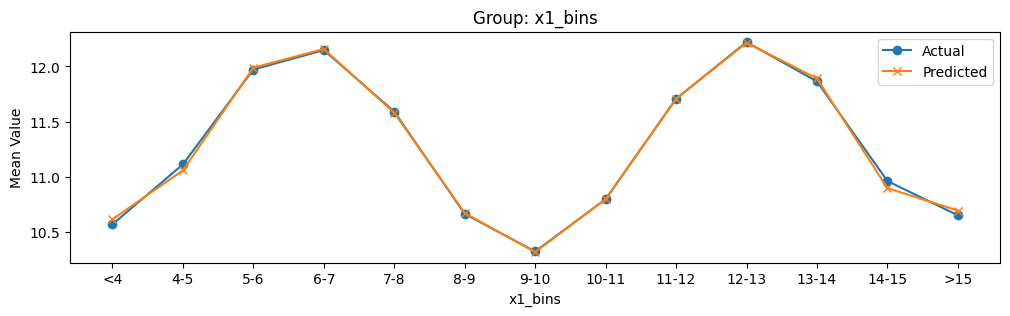

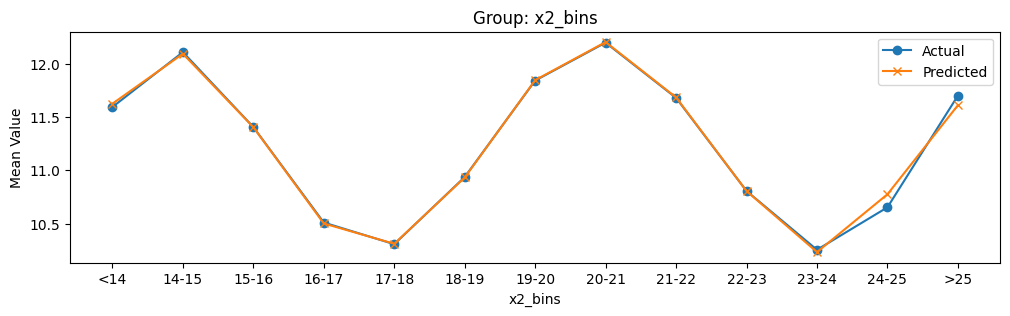

In [21]:
df['alternating_ols_predict'] = forward(curr_params_blocks, feature_blocks)
for group in ['x1_bins', 'x2_bins']:
    plt.figure(figsize=(12, 3))
    summary = df.groupby(group, observed=True).agg({'y': 'mean', 'alternating_ols_predict': 'mean'})
    plt.plot(summary.index, summary['y'], label='Actual', marker='o')
    plt.plot(summary.index, summary['alternating_ols_predict'], label='Predicted', marker='x')
    plt.title(f'Group: {group}')
    plt.xlabel(group)
    plt.ylabel('Mean Value')
    plt.legend()

In [22]:
x1_scaler = np.mean( feature_blocks['x1'] @ curr_params_blocks['x1'] )

for i, feat in enumerate(feature_groups['x1']):
    print(f"{feat:<10} {curr_params_blocks['x1'][i] / x1_scaler:.5f}")

x1_bias    1.65565
x1_le_4    -0.02489
x1_4_5     0.11501
x1_5_6     0.05827
x1_6_7     -0.01798
x1_7_8     -0.08774
x1_8_9     -0.07431
x1_9_10    0.00817
x1_10_11   0.08110
x1_11_12   0.08168
x1_12_13   0.00634
x1_13_14   -0.07227
x1_14_15   -0.10801
x1_gt_15   0.03469


In [23]:
x2_scaler = np.mean( feature_blocks['x2'] @ curr_params_blocks['x2'] )

for i, feat in enumerate(feature_groups['x2']):
    print(f"{feat:<10} {curr_params_blocks['x2'][i] / x2_scaler:.5f}")

x2_bias    0.71395
x2_le_14   0.05153
x2_14_15   -0.02458
x2_15_16   -0.09325
x2_16_17   -0.06661
x2_17_18   0.02229
x2_18_19   0.08757
x2_19_20   0.07468
x2_20_21   -0.00873
x2_21_22   -0.08203
x2_22_23   -0.08004
x2_23_24   -0.01602
x2_24_25   0.12035
x2_gt_25   0.00904


In [24]:
x2_scaler * x1_scaler

np.float64(11.249723103447295)